In [1]:
import convokit

In [2]:
corpus = convokit.Corpus(filename="/root/.convokit/downloads/supreme-corpus")

KeyboardInterrupt: 

In [4]:
corpus.print_summary_stats()

Number of Speakers: 8979
Number of Utterances: 1700789
Number of Conversations: 7817


<AxesSubplot:>

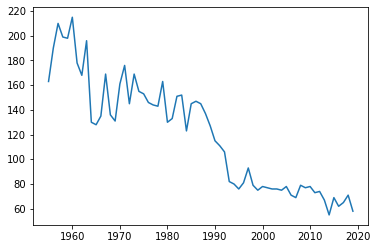

In [7]:
import pandas as pd
case_ids = [corpus.conversations[convo].meta['case_id'] for convo in corpus.conversations]
years = pd.Series([int(id[:4]) for id in case_ids])
years.value_counts().sort_index().plot()

In [10]:
convo = corpus.random_conversation()
meta: convokit.ConvoKitMeta = convo.meta

In [11]:
meta.get('win_side'), meta.get('votes_side')

(0,
 {'j__william_o_douglas': 0,
  'j__potter_stewart': 0,
  'j__thurgood_marshall': 0,
  'j__william_j_brennan_jr': 0,
  'j__byron_r_white': 0,
  'j__warren_e_burger': 0,
  'j__harry_a_blackmun': 0,
  'j__lewis_f_powell_jr': 0,
  'j__william_h_rehnquist': 0})

# Get chunks

In [13]:
def get_chunks_from(convo: convokit.Conversation):
  df = convo.get_utterances_dataframe()
  chunks = []
  cur_chunk = []
  cur_dyad = []
  chunk_start = 0
  while chunk_start < len(df):
    # greedily extract chunk
    label = df.index[chunk_start]
    speaker = df.iloc[chunk_start]['speaker']
    speaker_type = df.iloc[chunk_start]['meta.speaker_type']
    
    if speaker_type != 'A':
      # chunks should begin with an advocate speaking
      chunk_start += 1
      continue
    
    # otherwise, begin a new chunk
    cur_dyad.append(speaker)

    chunk_end = chunk_start
    while chunk_end < len(df):
      label2 = df.index[chunk_end]
      speaker2 = df.iloc[chunk_end]['speaker']
      speaker2_type = df.iloc[chunk_end]['meta.speaker_type']
      if speaker2_type == 'A' and speaker2 not in cur_dyad:
        # chunks should have only 1 advocate
        break
      elif speaker2_type == 'J' and speaker2 not in cur_dyad:
        if len(cur_dyad) == 2:
          # chunks should have only 1 justice
          break
        else:
          # this is the first time we've encountered a new justice
          cur_dyad.append(speaker2)

      cur_chunk.append(label2)
      chunk_end += 1
    
    if len(cur_chunk) >= 4:
      # chunks must have at least 4 utterances
      chunks.append(cur_chunk)
      # allow the next chunk to start using the end of this chunk
      chunk_start = chunk_end - 1 
    else:
      # try to start a chunk at the next utterance
      chunk_start += 1
    
    cur_chunk = []
    cur_dyad = []

  return chunks

chunks = get_chunks_from(convo)

In [15]:
convo.get_utterances_dataframe().loc[chunks[1], ['speaker', 'text']]

,speaker,text
id,,
15688__0_005,bernard_dunau,"With respect to a person who did not resign, t..."
15688__0_006,j__harry_a_blackmun,Mr. Dunau?
15688__0_007,bernard_dunau,Yes sir.
15688__0_008,j__harry_a_blackmun,"It may not be important, but I'm a little fuzz..."
15688__0_009,bernard_dunau,"No sir, we do not know and we can never know b..."
15688__0_010,j__harry_a_blackmun,Does the record show whether each person fined...
15688__0_011,bernard_dunau,I believe the record will show that Your Honor...
15688__0_012,j__harry_a_blackmun,"One last question, I take it does show that th..."
15688__0_013,bernard_dunau,"Yes sir, it will show when the letter of resig..."


# Old get gender method

In [42]:
from enum import Enum

class Gender(Enum):
  MALE = 0
  FEMALE = 1

  @property
  def honorific(self):
    if self == Gender.MALE:
      return 'Mr.'
    else:
      return 'Ms.'

In [125]:
def get_advocate_genders(convo: convokit.Conversation):
  speakers = convo.get_speakers_dataframe()
  is_advocate = speakers['meta.type'] == 'A'
  lastnames = speakers.loc[is_advocate, 'meta.name'] \
    .apply(lambda n: n.split(' ')[-1])

  advocate_genders = pd.Series(None, index=lastnames.index, name='gender', dtype=object)

  for advocate_id in advocate_genders.index:
    genders_found = [
      gender for gender in Gender
      if convo.get_utterances_dataframe().text.str.contains(gender.honorific + ' ' + lastnames[advocate_id]).any()
    ]
    
    if len(genders_found) == 1:
      advocate_genders[advocate_id] = genders_found[0]

  return advocate_genders

In [150]:
from IPython.display import clear_output

advocate_genders_per_convo = {}
convo_ids = corpus.get_conversation_ids()
for i, convo_id in enumerate(convo_ids):
  if i % 100 == 0:
    clear_output(wait=True)
    print(i, '/', len(convo_ids))
  convo = corpus.get_conversation(convo_id)
  advocate_genders_per_convo[convo_id] = get_advocate_genders(convo)

2100 / 7817


# New get gender method

In [478]:
from nameparser import HumanName

advocate_names = corpus.get_speakers_dataframe(lambda s: s.get_meta().get('type') == 'A') \
  .rename(columns={'meta.name': 'name'})[['name']]
advocate_names['lastname'] = advocate_names['name'].apply(lambda n: HumanName(n).last)
advocate_names['male_honorific'] = 'Mr. ' + advocate_names['lastname']
advocate_names['female_honorific'] = 'Ms. ' + advocate_names['lastname']

In [ ]:
all_advocates = all_convos['meta.advocates'].apply(lambda a: a.keys()) \
  .explode() \
  .replace('', None) \
  .dropna() \
  .reset_index() \
  .rename(columns={'id': 'conversation_id', 'meta.advocates': 'advocate_id'})

In [ ]:
advocate_names.index.symmetric_difference(honorifics_uttered.index)

In [165]:
all_convos = corpus.get_conversations_dataframe()

In [400]:
advocates = all_convos['meta.advocates'].apply(lambda a: a.keys()).explode().to_frame().rename(columns={'meta.advocates': 'advocate_id'})
advocates['lastname'] = advocates['advocate_id'].str.split('_').str[-1].str.capitalize()
advocates['male_honorific'] = 'Mr. ' + lastnames
advocates['female_honorific'] = 'Ms. ' + lastnames

In [ ]:
mr_utterances = corpus.get_utterances_dataframe(selector=lambda u: 'Mr.' in u.text, exclude_meta=True)
ms_utterances = corpus.get_utterances_dataframe(selector=lambda u: 'Ms.' in u.text, exclude_meta=True)

In [531]:
j_mr_utt = mr_utterances[mr_utterances.speaker.str.contains('j__')].copy().set_index('conversation_id')['text'].str.findall(r'Mr. \w+')
j_mr_utt.name = 'j_mr_honorifics_uttered'
j_ms_utt = ms_utterances[ms_utterances.speaker.str.contains('j__')].copy().set_index('conversation_id')['text'].str.findall(r'Ms. \w+')
j_ms_utt.name = 'j_ms_honorifics_uttered'

honorifics_uttered = all_advocates.merge(j_mr_utt.groupby(level=0).sum().reset_index(), on='conversation_id') \
  .merge(j_ms_utt.groupby(level=0).sum().reset_index(), on='conversation_id') \
  .groupby('advocate_id')[['j_mr_honorifics_uttered', 'j_ms_honorifics_uttered']].sum().apply(np.vectorize(set))

In [538]:
advocate_names.index.intersection(honorifics_uttered.index)

Index(['joseph_forer', 'john_j_abt', 'marvin_e_frankel', 'daniel_m_friedman',
       'oscar_h_davis', 'a_l_wirin', 'bessie_margolin', 'milton_c_denbo',
       'mark_f_hughes', 'willard_s_johnston',
       ...
       'monica_l_miller', 'jeffrey_m_harris', 'michael_j_mongan',
       'jessica_e_mendez-colberg', 'kendall_turner', 'k_winn_allen',
       'julie_rikelman', 'sarah_schrup', 'toby_crouse', 'eric_c_rassbach'],
      dtype='object', length=1683)

In [539]:
advocate_names.join(honorifics_uttered, how='inner')

,name,lastname,male_honorific,female_honorific,j_mr_honorifics_uttered,j_ms_honorifics_uttered
joseph_forer,Joseph Forer,Forer,Mr. Forer,Ms. Forer,"{Mr. Forer, Mr. Kardy, Mr. Chayes, Mr. Prescot...","{Ms. Lynn, Ms. Flynn}"
john_j_abt,John J. Abt,Abt,Mr. Abt,Ms. Abt,"{Mr. Forer, Mr. Maroney, Mr. Chayes, Mr. Abt, ...","{Ms. Chapp, Ms. Flynn}"
marvin_e_frankel,Marvin E. Frankel,Frankel,Mr. Frankel,Ms. Frankel,"{Mr. Frankel, Mr. Young, Mr. Chanin}",{Ms. French}
daniel_m_friedman,Daniel M. Friedman,Friedman,Mr. Friedman,Ms. Friedman,"{Mr. Goldberg, Mr. Lane, Mr. Tavenner, Mr. Niz...",{Ms. Rogers}
oscar_h_davis,Oscar H. Davis,Davis,Mr. Davis,Ms. Davis,"{Mr. Boudin, Mr. Davis}",{Ms. Elg}
...,...,...,...,...,...,...
k_winn_allen,K. Winn Allen,Allen,Mr. Allen,Ms. Allen,{Mr. Allen},"{Ms. Kendall, Ms. Ratner, Ms. Turner}"
julie_rikelman,Julie Rikelman,Rikelman,Mr. Rikelman,Ms. Rikelman,{Mr. Wall},{Ms. Rikelman}
sarah_schrup,Sarah Schrup,Schrup,Mr. Schrup,Ms. Schrup,"{Mr. Crouse, Mr. Chief}","{Ms. Schrup, Ms. Prelogar}"
toby_crouse,Toby Crouse,Crouse,Mr. Crouse,Ms. Crouse,"{Mr. Crouse, Mr. Chief, Mr. So, Mr. Huston}","{Ms. Schrup, Ms. Prelogar, Ms. Harrington}"


In [335]:
advocates['matched_mr'] = advocates.apply(lambda a: a['male_honorific'] in a['j_mr_honorifics_uttered'] if type(a['j_mr_honorifics_uttered']) == set else False, axis=1)
advocates['matched_ms'] = advocates.apply(lambda a: a['female_honorific'] in a['j_ms_honorifics_uttered'] if type(a['j_ms_honorifics_uttered']) == set else False, axis=1)

In [337]:
advocates['gender'] = None
advocates.loc[matched_mr & ~matched_ms, 'gender'] = False  # male
advocates.loc[~matched_mr & matched_ms, 'gender'] = True   # female

In [371]:
advocates[advocates.advocate_id == 'wray_g_zelt_jr']

,advocate_id,lastname,male_honorific,female_honorific,j_mr_honorifics_uttered,j_ms_honorifics_uttered,matched_mr,matched_ms,gender
13105,wray_g_zelt_jr,Jr,Mr. Jr,Ms. Jr,"{Mr. Zelt, Mr. Roney, Mr. District, Mr. Levy}","{Ms. Watson, Ms. Matson}",False,False,None


In [345]:
advocates.j_ms_honorifics_uttered.notna().sum()

3076

In [342]:
advocates.gender.sum(), advocates.gender.isna().sum(), len(advocates)

(1108, 5416, 20601)

In [348]:
is_m = advocates.groupby('advocate_id').gender.min()
is_f = advocates.groupby('advocate_id').gender.max()

In [389]:
is_m == is_f

advocate_id
                       False
a_alan_reich            True
a_alvis_layne           True
a_b_howland             True
a_benjamin_goldgar      True
                       ...  
zachary_d_tripp         True
zackery_p_morazzini     True
zane_d_wilson           True
zona_f_hostetler       False
zygmunt_j_b_plater      True
Name: gender, Length: 9331, dtype: bool

In [392]:
(is_m.isna() & is_f.notna()).sum()

0

In [393]:
is_m

advocate_id
                         NaN
a_alan_reich           False
a_alvis_layne          False
a_b_howland            False
a_benjamin_goldgar     False
                       ...  
zachary_d_tripp        False
zackery_p_morazzini    False
zane_d_wilson          False
zona_f_hostetler         NaN
zygmunt_j_b_plater     False
Name: gender, Length: 9331, dtype: object

In [388]:
is_f

advocate_id
                         NaN
a_alan_reich           False
a_alvis_layne          False
a_b_howland            False
a_benjamin_goldgar     False
                       ...  
zachary_d_tripp        False
zackery_p_morazzini    False
zane_d_wilson          False
zona_f_hostetler         NaN
zygmunt_j_b_plater     False
Name: gender, Length: 9331, dtype: object

In [384]:
is_m[is_m == is_f]

advocate_id
a_alan_reich           False
a_alvis_layne          False
a_b_howland            False
a_benjamin_goldgar     False
a_c_epps               False
                       ...  
zachary_d_fasman       False
zachary_d_tripp        False
zackery_p_morazzini    False
zane_d_wilson          False
zygmunt_j_b_plater     False
Name: gender, Length: 7615, dtype: object

In [380]:
is_f.sum(), is_m.sum(), (is_m == is_f).mean()

(613, 609, 0.8160968813631979)

In [376]:
x=(is_m != is_f).to_frame().reset_index()
x=x[x.gender]
x=x[~x.advocate_id.str.contains('jr')]
x

,advocate_id,gender
0,,True
11,a_donald_mackinnon,True
37,a_w_sorelle_iii,True
71,adam_yarmolinsky,True
72,addison_lane_mcgovern,True
...,...,...
9289,william_w_porter,True
9312,wm_e_lamoreaux,True
9316,wood_brown_iii,True
9323,yvette_hall_war_bonnett,True


In [359]:
is_m[is_m != is_f]

advocate_id
                           NaN
a_donald_mackinnon         NaN
a_felton_jenkins_jr        NaN
a_p_carlton_jr             NaN
a_raymond_randolph_jr      NaN
                          ... 
woodrow_m_melvin_jr        NaN
wray_g_zelt_jr             NaN
yvette_hall_war_bonnett    NaN
z_t_osborn_jr              NaN
zona_f_hostetler           NaN
Name: gender, Length: 1716, dtype: object

In [350]:
(is_m == is_f).mean()

0.8160968813631979